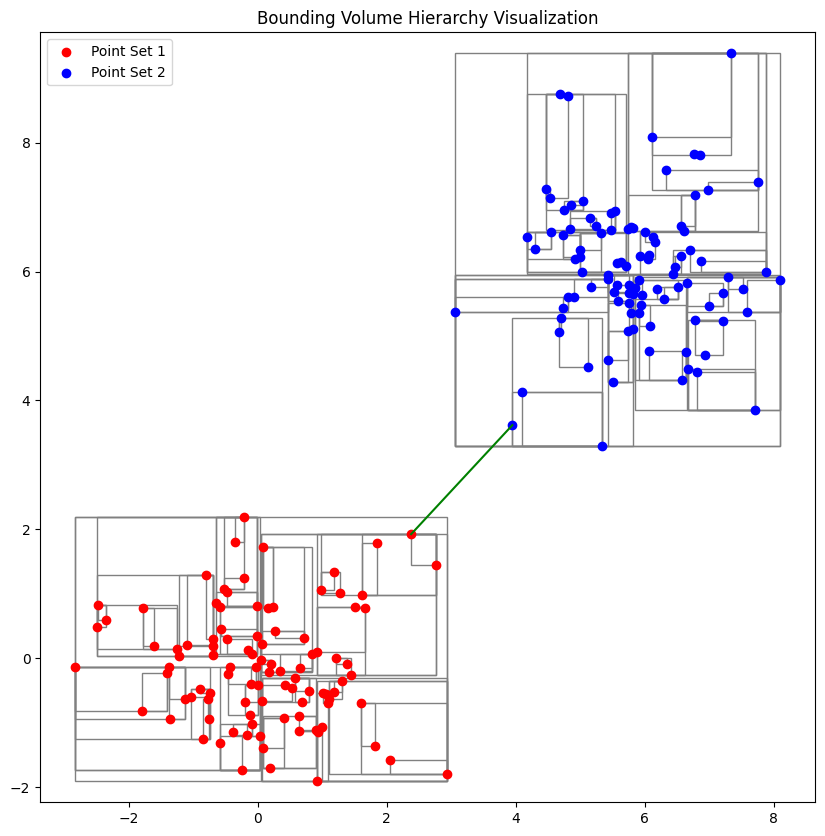

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 두 개의 랜덤 포인트 집합 생성
pts1 = np.random.randn(100, 2)  # 빨간 점들
pts2 = np.random.randn(100, 2) + np.array([6, 6])  # 파란 점들

def bvh(pts):
    if (N := len(pts)) == 1: 
        pt = pts[0]
        return { 'bbox': (*pt, *pt), 'children': [] }
    (x_min, y_min), (x_max, y_max) = pts.min(0), pts.max(0)
    axis = 0 if x_max - x_min >= y_max - y_min else 1
    pts = pts[pts[:,axis].argsort()]
    return {
        'bbox': (x_min, y_min, x_max, y_max),
        'children': (bvh(pts[:N//2]), bvh(pts[N//2:]))
    }

def draw(bvh, ax, color='gray'):
    x_min, y_min, x_max, y_max = bvh['bbox']
    rect = patches.Rectangle(
        (x_min, y_min), x_max - x_min, y_max - y_min, 
        linewidth=1, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    for child in bvh['children']:
        draw(child, ax, color)


def shortest_distance(bvh1, bvh2):
    
    def squared_distance(bvh1, bvh2):
        bbox1, bbox2 = bvh1['bbox'], bvh2['bbox']
        dx = max(bbox1[0] - bbox2[2], bbox2[0] - bbox1[2], 0)
        dy = max(bbox1[1] - bbox2[3], bbox2[1] - bbox1[3], 0)
        return (dx * dx + dy * dy, bvh1, bvh2)
    
    
    from heapq import heappush, heappop
    min_heap = []
    heappush(min_heap, squared_distance(bvh1, bvh2))
    
    while min_dist := heappop(min_heap):
        _, bvh1, bvh2 = min_dist
        if bvh1['children']:
            heappush(min_heap, squared_distance(bvh2, bvh1['children'][0]))
            heappush(min_heap, squared_distance(bvh2, bvh1['children'][1]))
        elif bvh2['children']:
            heappush(min_heap, squared_distance(bvh2['children'][0], bvh1))
            heappush(min_heap, squared_distance(bvh2['children'][1], bvh1))
        else:
            return bvh1['bbox'][:2], bvh2['bbox'][:2]


bvh1, bvh2 = bvh(pts1), bvh(pts2)
# 시각화
fig, ax = plt.subplots(figsize=(10, 10))
draw(bvh1, ax)  # 빨간 점의 BVH 그리기
draw(bvh2, ax)  # 파란 점의 BVH 그리기
ax.scatter(pts1[:, 0], pts1[:, 1], color='red', label='Point Set 1')
ax.scatter(pts2[:, 0], pts2[:, 1], color='blue', label='Point Set 2')
ax.set_title('Bounding Volume Hierarchy Visualization')
ax.legend()
plt.axis('equal')
# plt.show()

pt1, pt2 = shortest_distance(bvh1, bvh2)
plt.plot((pt1[0], pt2[0]), (pt1[1], pt2[1]), color='g')